We have three aims here: 1) plotting the data to see the trend, 2) understanding whether at some points emissions were lower than in the previous month (CO2 accumulates so this means emitting less AND enough to offset some of the CO2 in the atmosphere), 3) understanding this more formally: use ARIMA to forecast increase in emissions month by month and see what the deviations are

Let's start by making sure we have what we need


In [1]:

import seaborn as sns
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import os

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Use white grid plot background from seaborn
sns.set(font_scale=1.5, style="whitegrid")

Now let's read the dataset- the sloppy notation in calling the dataset "data" makes the code easier to replicate. Here we also check the type of data we have.

In [2]:
data = pd.read_excel('NOAACO2simple.xlsx')
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 3 columns):
date               750 non-null datetime64[ns]
average            750 non-null float64
monthlyincrease    750 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 17.7 KB


To make sure we have the right date form we can also take a look at the following code.

In [3]:

# Check data type of first value in date column
type(data['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In the interest of replicability, if we wanted to set the date as a datetime object this is what we would do.

In [61]:
#making sure date is taken correctly as a datetime object
parse_dates = ['date_column']
index_col = ['date_column']
pd.period_range('1958-03', periods=750, freq='M')

PeriodIndex(['1958-03', '1958-04', '1958-05', '1958-06', '1958-07', '1958-08',
             '1958-09', '1958-10', '1958-11', '1958-12',
             ...
             '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04',
             '2020-05', '2020-06', '2020-07', '2020-08'],
            dtype='period[M]', length=750, freq='M')

This is all in the right format, now let's take a look at a simple plot showing us the evolution of the average CO2 levels in the US.

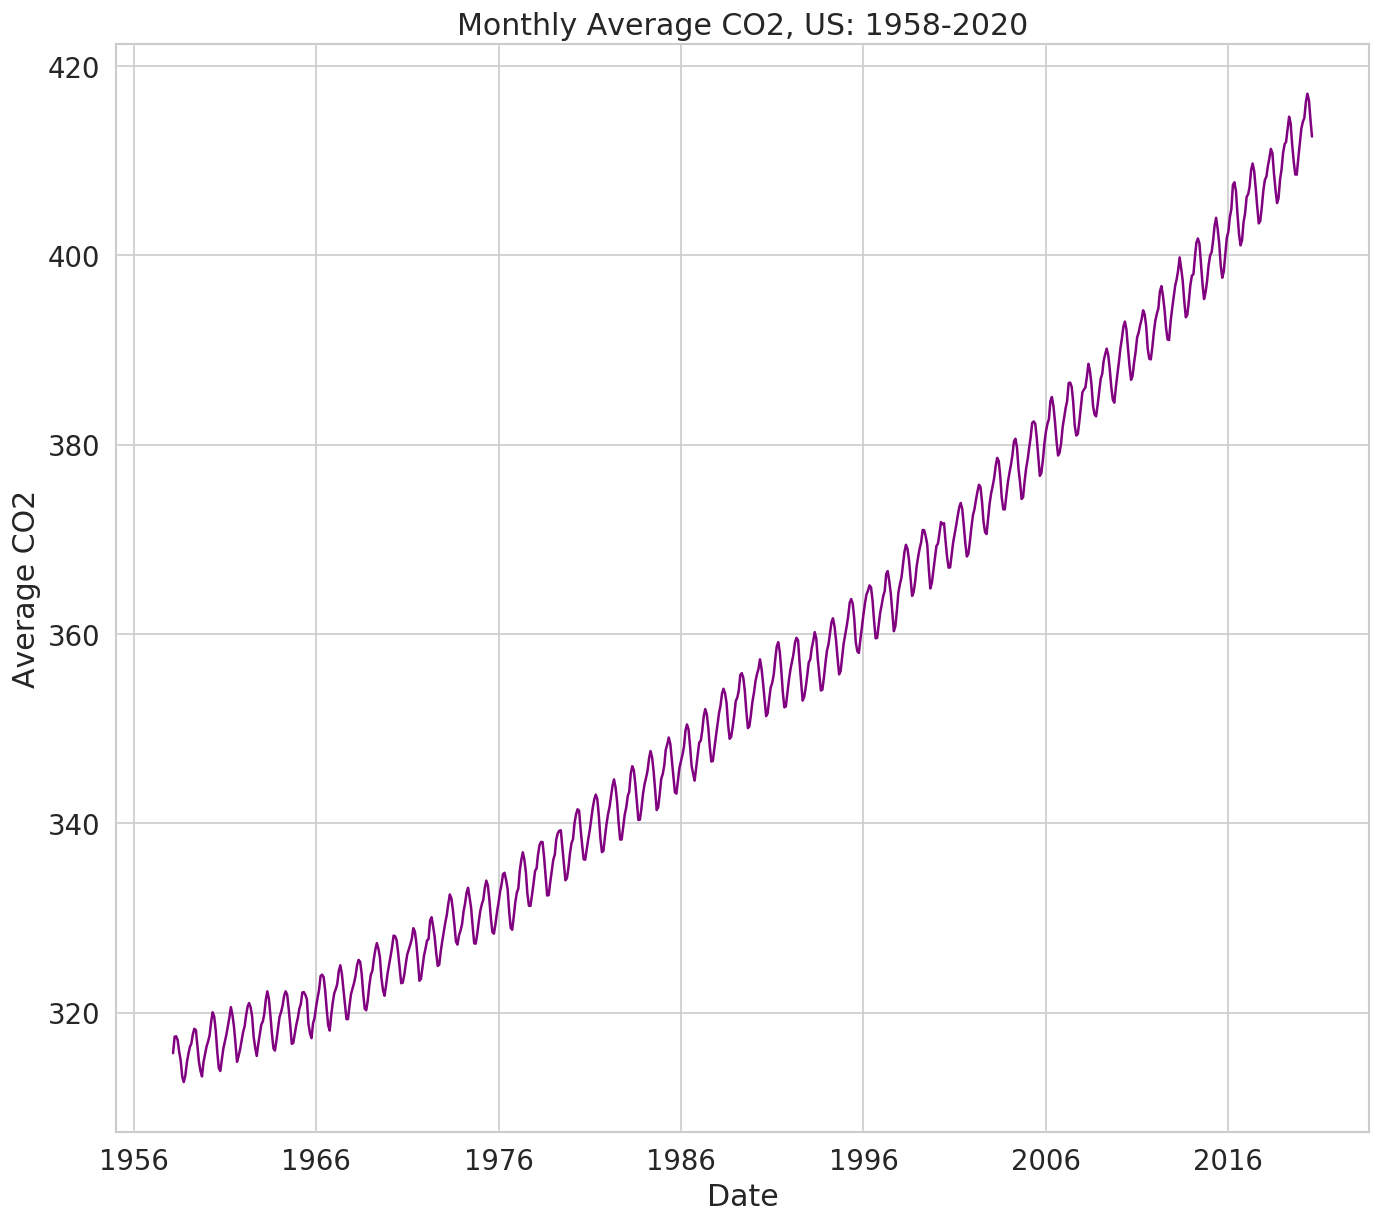

In [62]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(12, 12))

# Add x-axis and y-axis
ax.plot(data['date'],
        data['average'],
        color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Average CO2",
       title="Monthly Average CO2, US: 1958-2020")

plt.show()

To play around we can also take a look at a scatterplot, to avoid being biased by the line plot in seeing a trend.

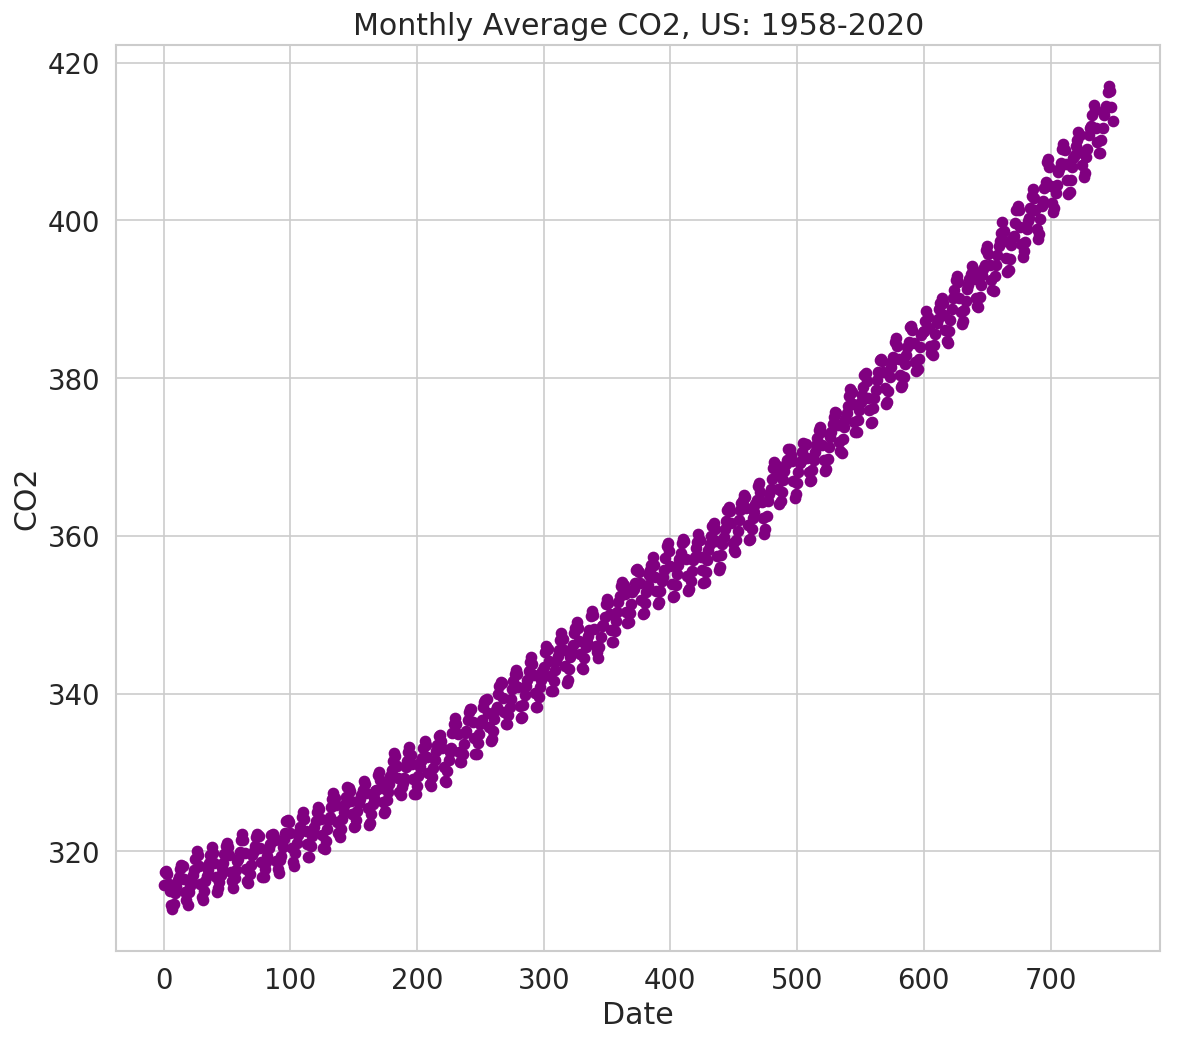

In [63]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.scatter(data.index.values,
        data['average'],
        color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="CO2",
       title="Monthly Average CO2, US: 1958-2020")

plt.show()

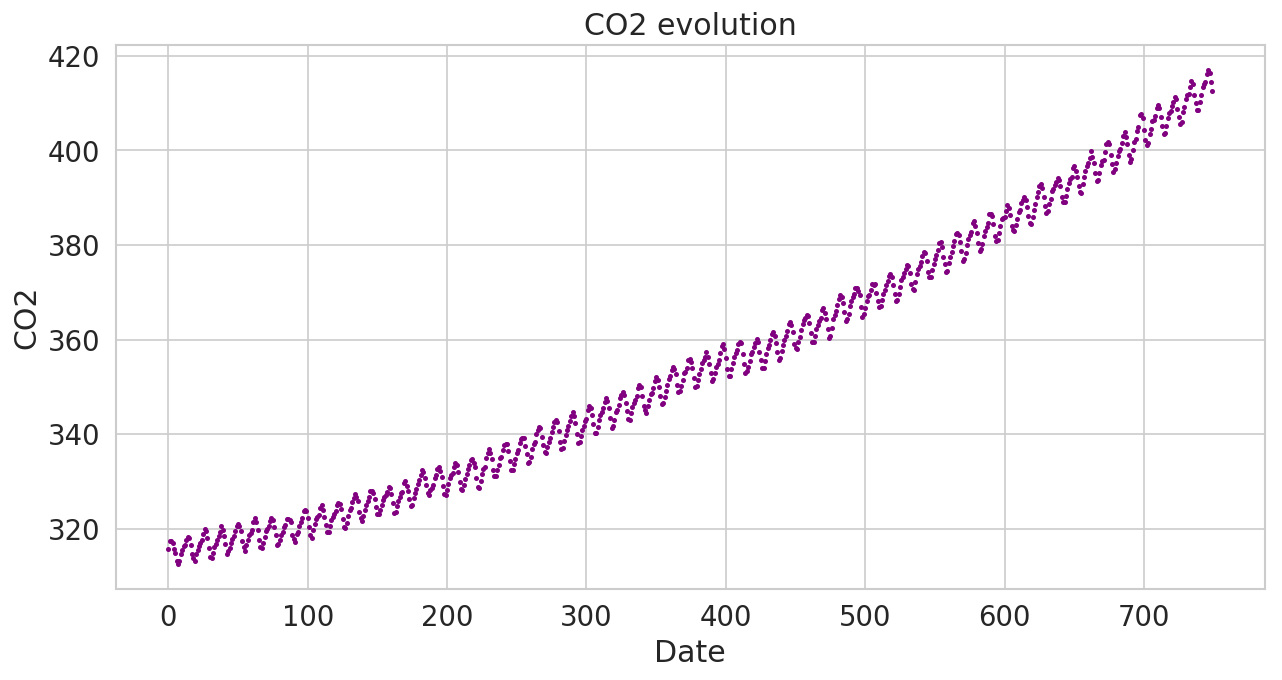

In [64]:
#  Plot using matplotlib
fig, ax = plt.subplots(figsize=(11, 6))

ax.scatter(x=data.index,
           y=data["average"],
           marker="o",
           s=4,
           color="purple")

ax.set(xlabel="Date", ylabel="CO2",
       title="CO2 evolution")

plt.show()

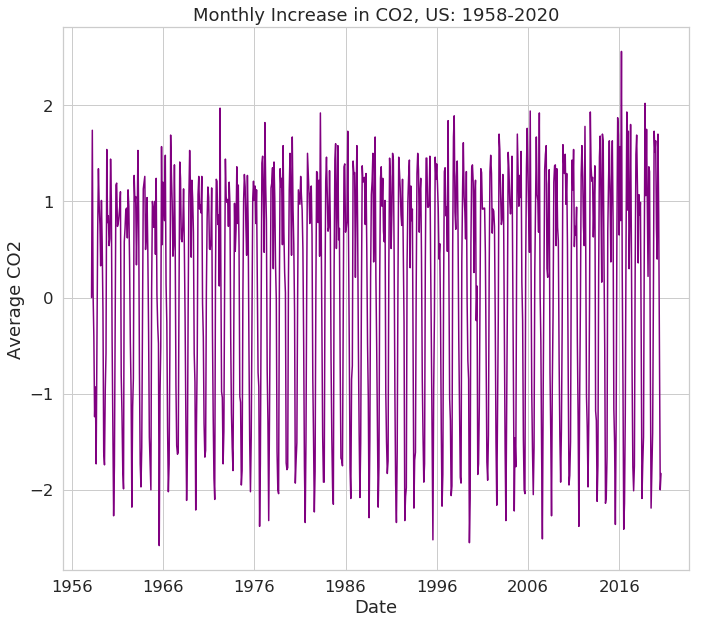

In [12]:
#Let's take a look at the monthly increase now (more on this later)
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.plot(data['date'],
        data['monthlyincrease'],
        color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Average CO2",
       title="Monthly Increase in CO2, US: 1958-2020")

plt.show()

First, I am going to check if the series is stationary using the Augmented Dickey Fuller test (adfuller()), 
#from the statsmodels package. The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

In [13]:
#this doesn't tell us much but has the benefit of looking like stationary data, let's start ARIMA
#before we use ARIMA to check monthly differences let's apply it to overall CO2

from statsmodels.tsa.stattools import adfuller
from numpy import log

    
result = adfuller(data['average'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: 5.302968
p-value: 1.000000


This data is clearly non-stationary so we need a full ARIMA (I different than zero). let’s difference the series and see how the autocorrelation plot looks like.

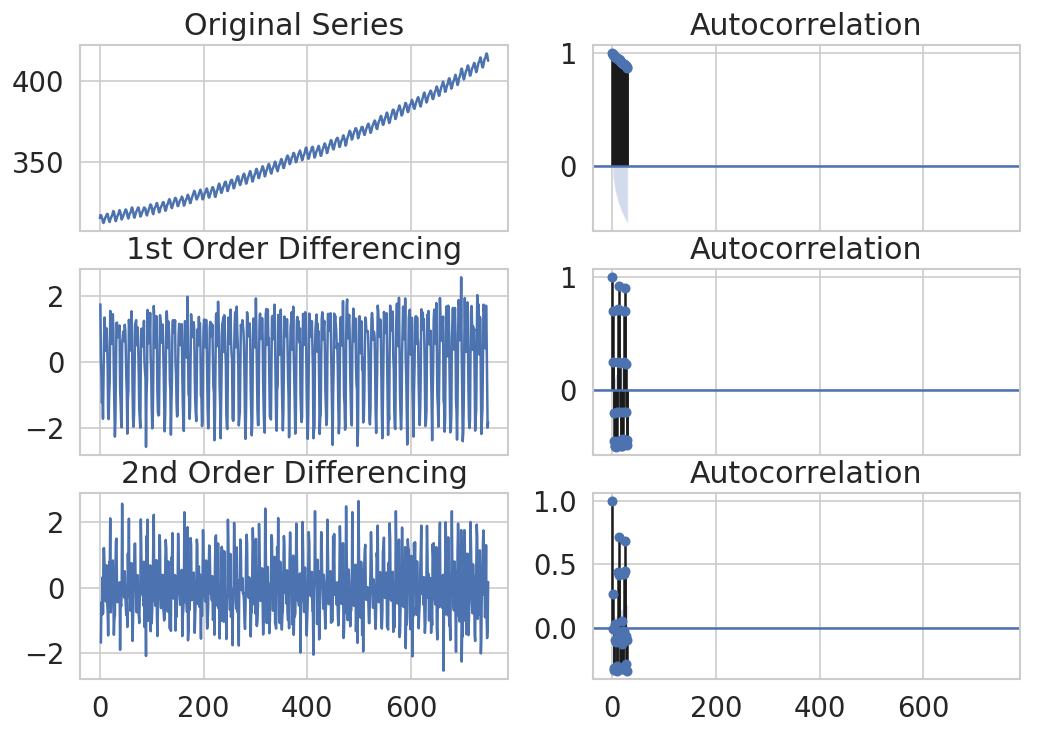

In [14]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(data.average); axes[0, 0].set_title('Original Series')
plot_acf(data.average, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data.average.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data.average.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data.average.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data.average.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

this is far from perfect, but suggests that even if not perfectly stationary data can become weakly stationarity given the right differencing. To avoid picking at random (and because d>2) let's use auto.arima to decide the parameters for our model.

In [15]:
#!pip install pmdarima


In [16]:
#!pip install pyramid-arima

In [17]:
#!pip uninstall numpy y
#!pip install --upgrade numpy
from pmdarima.arima import auto_arima

In [21]:
from pmdarima.arima.utils import ndiffs

y = data.average

## Adf Test
ndiffs(data.average, test='adf')  

 

1

In [22]:
# KPSS test
ndiffs(data.average, test='kpss') 
 

1

In [23]:
# PP test:
ndiffs(data.average, test='pp')

0

In [25]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,0 ARIMA Model
model = ARIMA(data.average, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:              D.average   No. Observations:                  749
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -914.896
Method:                       css-mle   S.D. of innovations              0.820
Date:                Sun, 04 Oct 2020   AIC                           1837.791
Time:                        16:42:34   BIC                           1856.266
Sample:                             1   HQIC                          1844.911
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1302      0.093      1.397      0.162      -0.052       0.313
ar.L1.D.average     0.5610      0.036     15.623      0.000       0.491       0.631
ma.L1.D.average     0.3683      

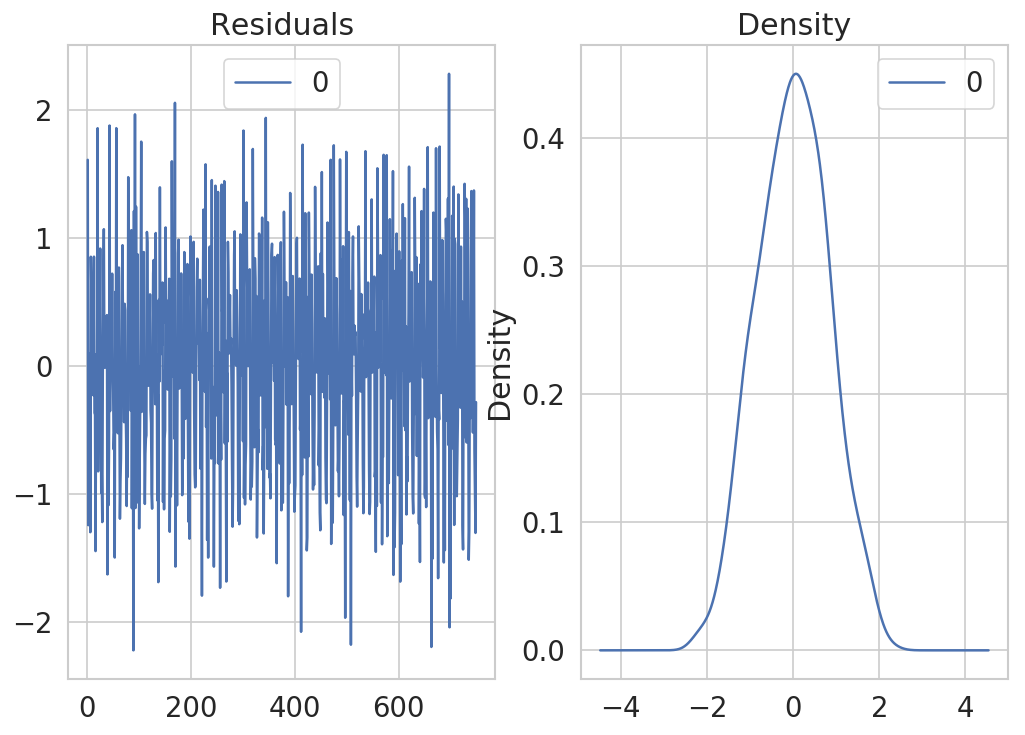

In [26]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

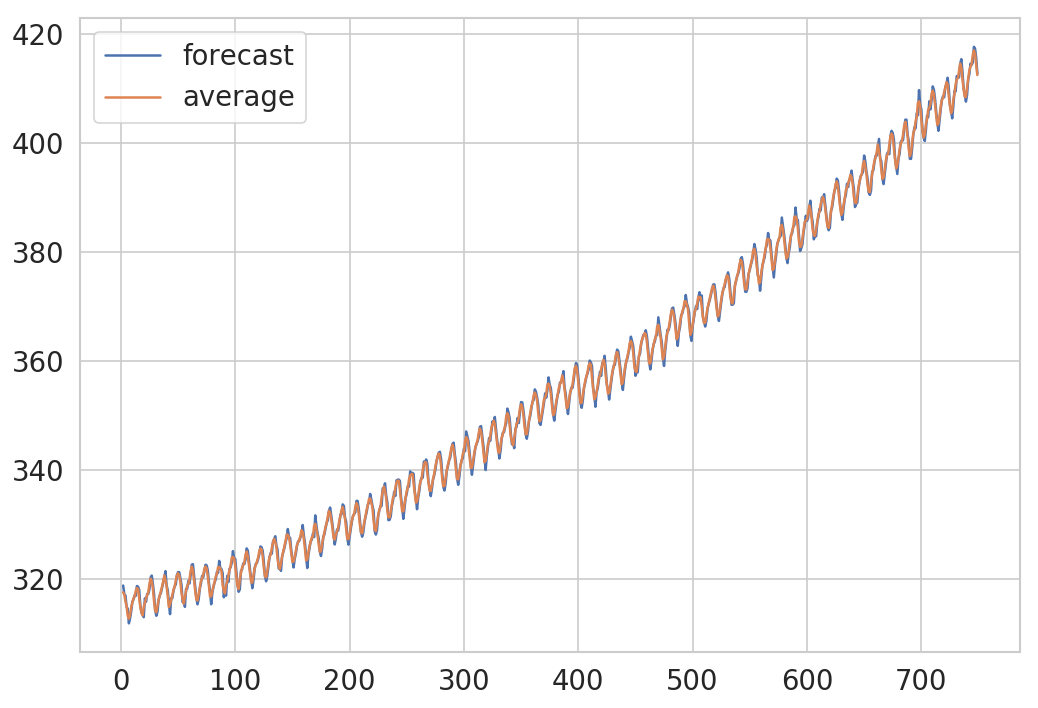

In [27]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [49]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = data.average[:744]
test = data.average[744:]

In [50]:
import pandas as pd

In [51]:
# Build Model
# model = ARIMA(train, order=(1,1,1)
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())




                             ARIMA Model Results                              
Dep. Variable:              D.average   No. Observations:                  743
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1194.723
Method:                       css-mle   S.D. of innovations              1.208
Date:                Sun, 04 Oct 2020   AIC                           2397.445
Time:                        17:49:45   BIC                           2415.888
Sample:                             1   HQIC                          2404.555
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1314      0.012     10.881      0.000       0.108       0.155
ar.L1.D.average     0.8705      0.022     38.924      0.000       0.827       0.914
ma.L1.D.average    -0.9657      

In [55]:
# Forecast
fc, se, conf = fitted.forecast(6, alpha=0.05)  # 95% conf

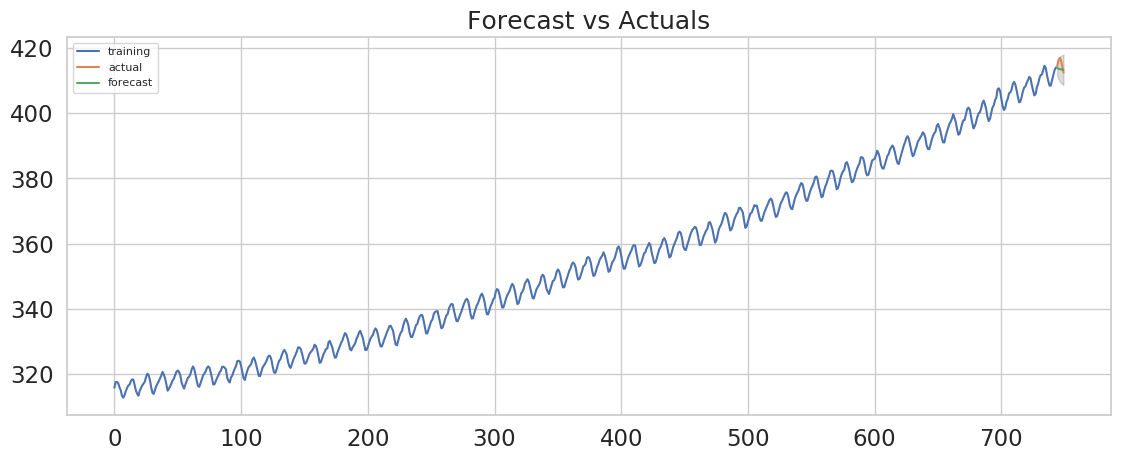

In [56]:
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [57]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


{'mape': 0.004483233950043064,
 'me': -1.5756354401169783,
 'mae': 1.8649708279013357,
 'mpe': -0.00378189983833695,
 'rmse': 2.168900110155441,
 'acf1': 0.29958568916802153,
 'corr': 0.29710031924751346,
 'minmax': 0.004482497694821341}

Now onto our difference from the month before

In [65]:
result = adfuller(data['monthlyincrease'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.127746
p-value: 0.000012


Data here is stationary! No need for differencing and our model simplifies to ARMA but let's check it a bit more.

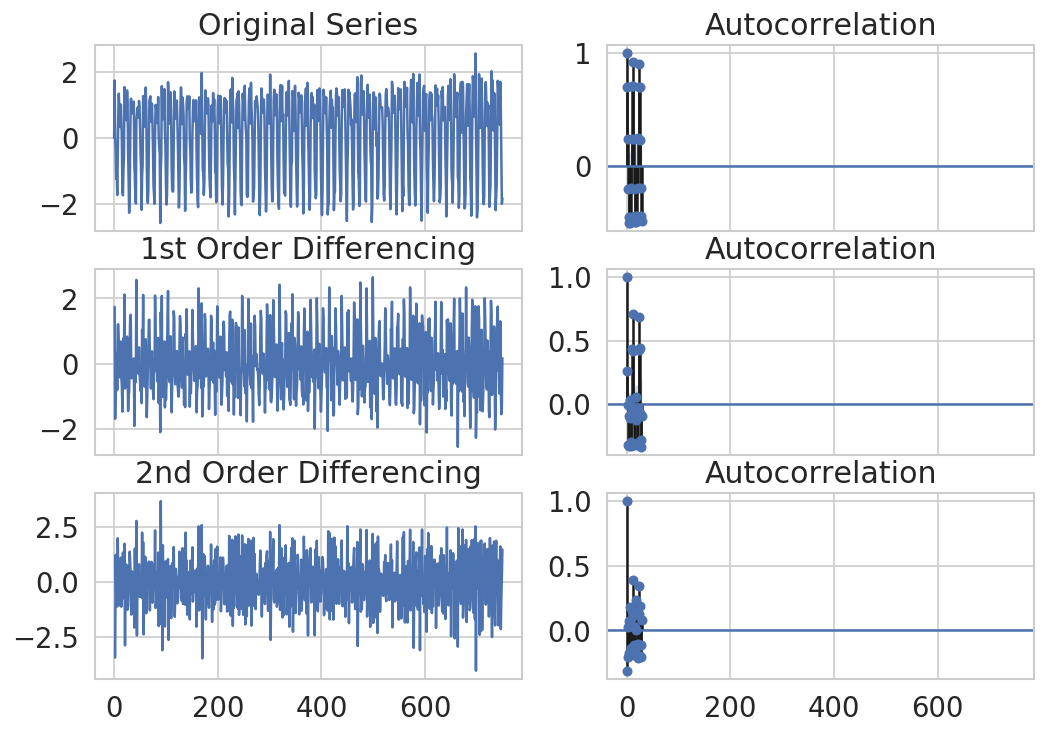

In [66]:

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(data.monthlyincrease); axes[0, 0].set_title('Original Series')
plot_acf(data.monthlyincrease, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data.monthlyincrease.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data.monthlyincrease.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data.monthlyincrease.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data.monthlyincrease.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [67]:


## Adf Test
ndiffs(data.monthlyincrease, test='adf')  

0

In [68]:
# KPSS test
ndiffs(data.monthlyincrease, test='kpss') 
 

0

In [69]:
# PP test:
ndiffs(data.monthlyincrease, test='pp')

0

Here we aren't really being helped so it will take a bit of guessing over the best ARMA

In [74]:
# 1,0,1 ARIMA Model
model = ARIMA(data.monthlyincrease, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:      D.monthlyincrease   No. Observations:                  749
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1000.391
Method:                       css-mle   S.D. of innovations              0.920
Date:                Sun, 04 Oct 2020   AIC                           2006.782
Time:                        18:22:46   BIC                           2020.638
Sample:                             1   HQIC                          2012.121
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0015      0.045     -0.034      0.973      -0.091       0.088
ar.L1.D.monthlyincrease     0.2614      0.035      7.400      0.000       0.192       0.331


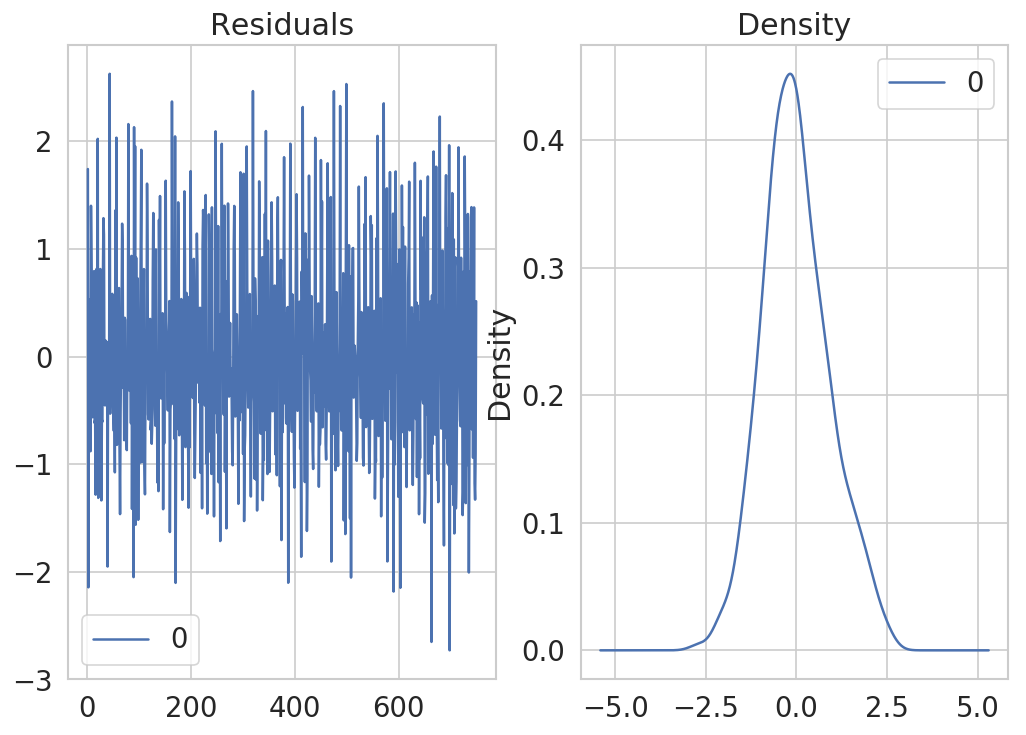

In [75]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [78]:


# Create Training and Test
train = data.monthlyincrease[:744]
test = data.monthlyincrease[744:]

# Build Model
# model = ARIMA(train, order=(1,1,0)
model = ARIMA(train, order=(1, 1, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())





                             ARIMA Model Results                              
Dep. Variable:      D.monthlyincrease   No. Observations:                  743
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -991.735
Method:                       css-mle   S.D. of innovations              0.919
Date:                Sun, 04 Oct 2020   AIC                           1989.471
Time:                        18:24:50   BIC                           2003.303
Sample:                             1   HQIC                          1994.803
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0014      0.046      0.030      0.976      -0.088       0.091
ar.L1.D.monthlyincrease     0.2615      0.035      7.368      0.000       0.192       0.331


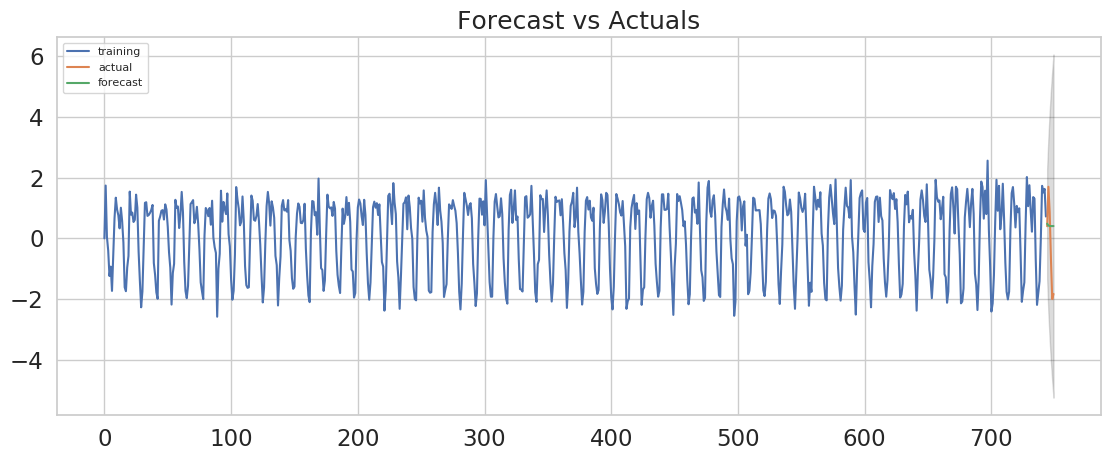

In [79]:
# Forecast
fc, se, conf = fitted.forecast(6, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [80]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


{'mape': 0.9159479432838111,
 'me': 0.6811204140856356,
 'mae': 1.2580288287083337,
 'mpe': -0.8467361102276286,
 'rmse': 1.5177851123320478,
 'acf1': 0.5721413006696657,
 'corr': 0.37674885778260636,
 'minmax': 2.602152826155608}